In [2]:
import json
import numpy as np
import gzip
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import os



In [3]:
# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)


In [4]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os 


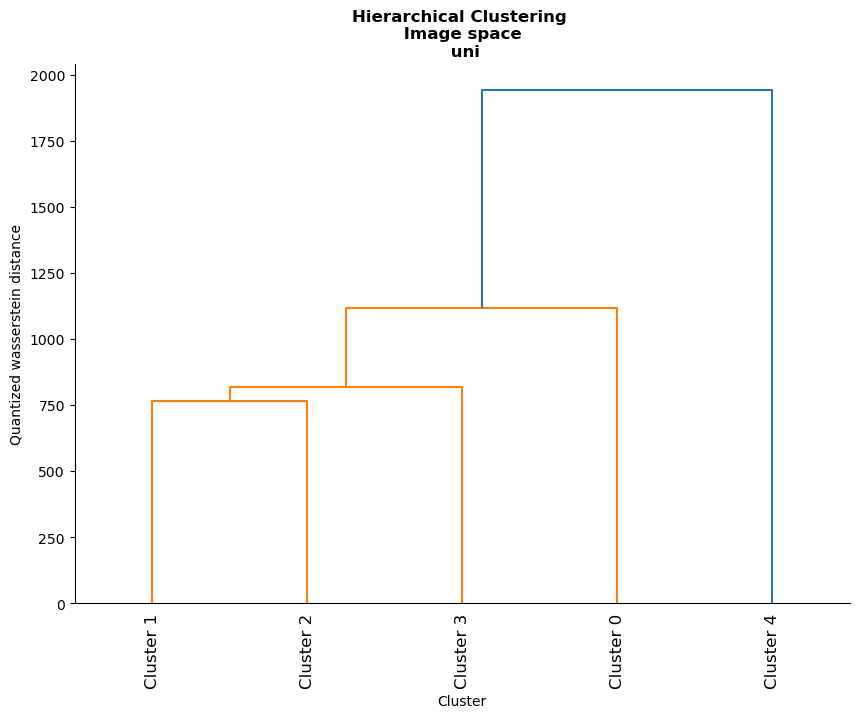

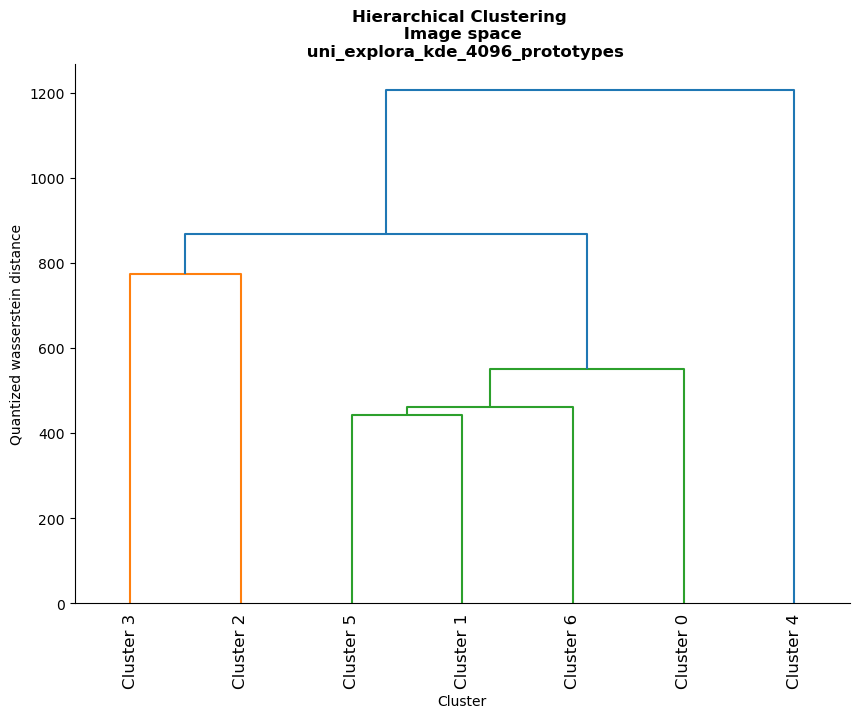

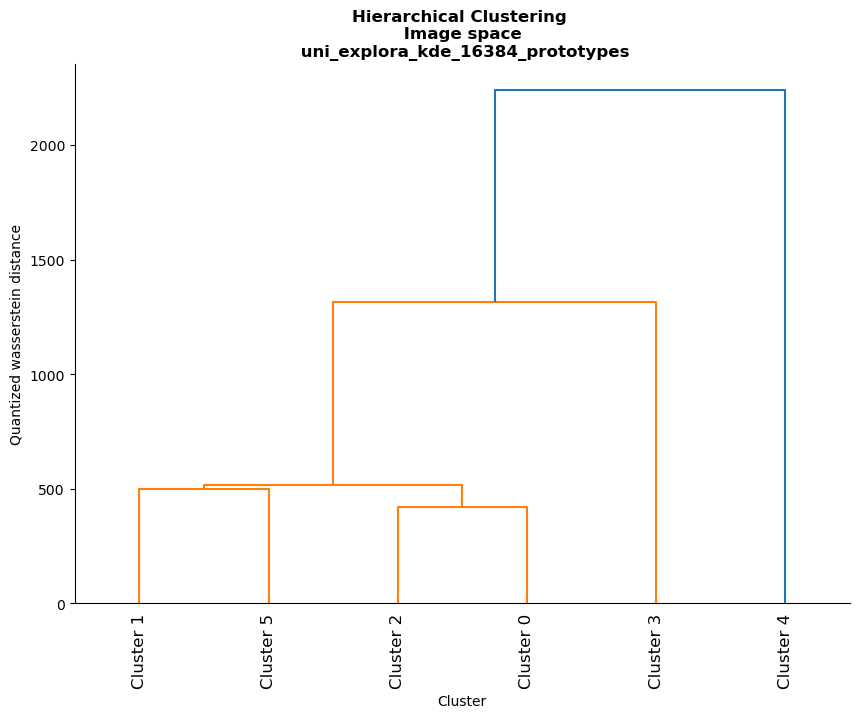

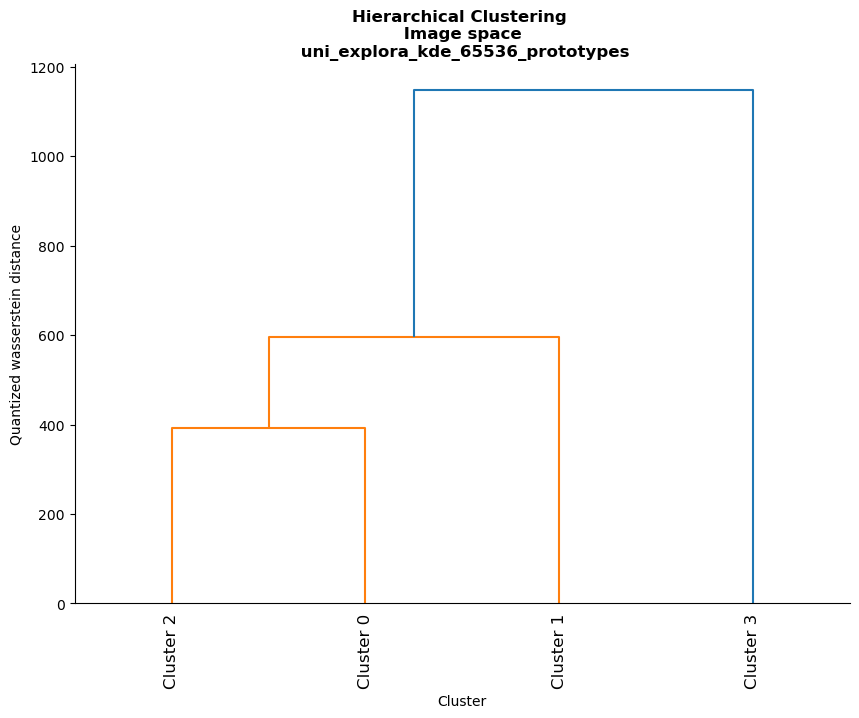

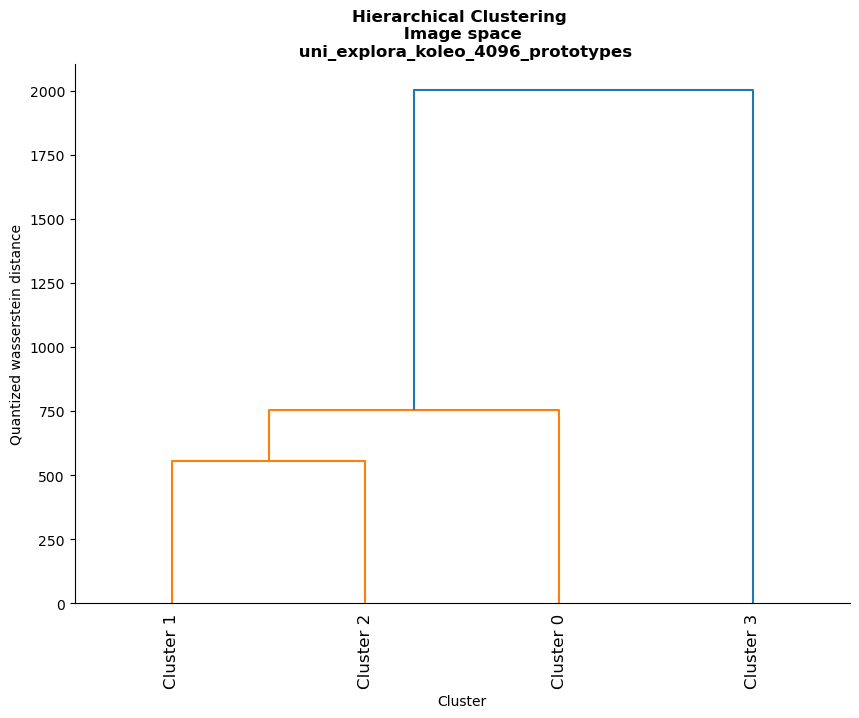

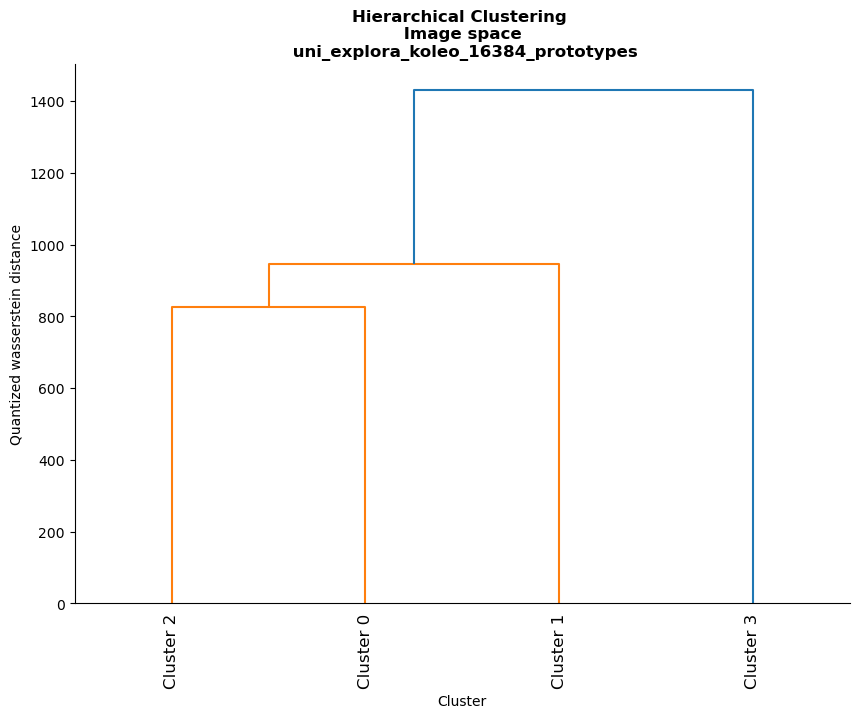

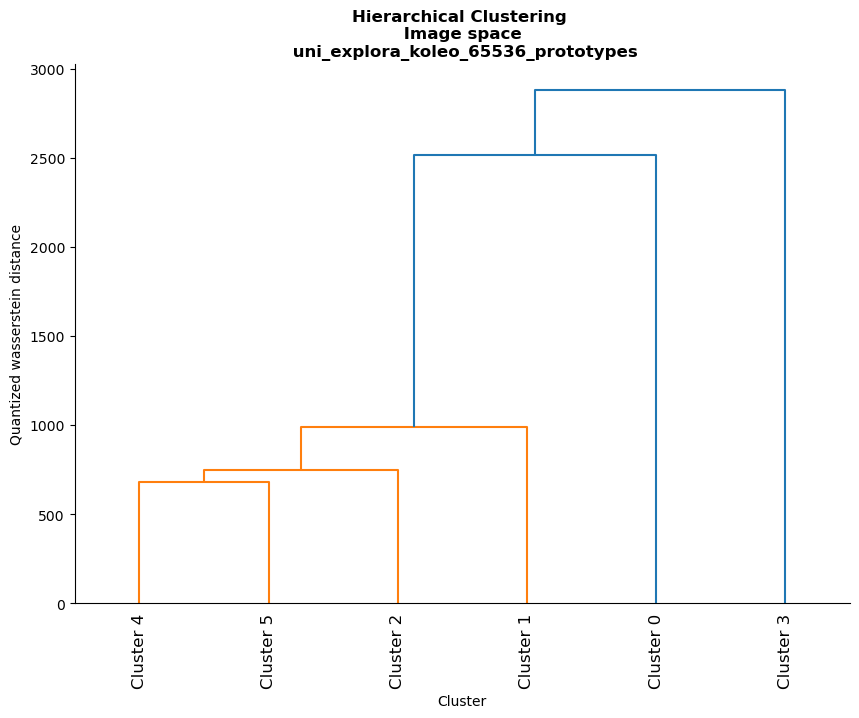

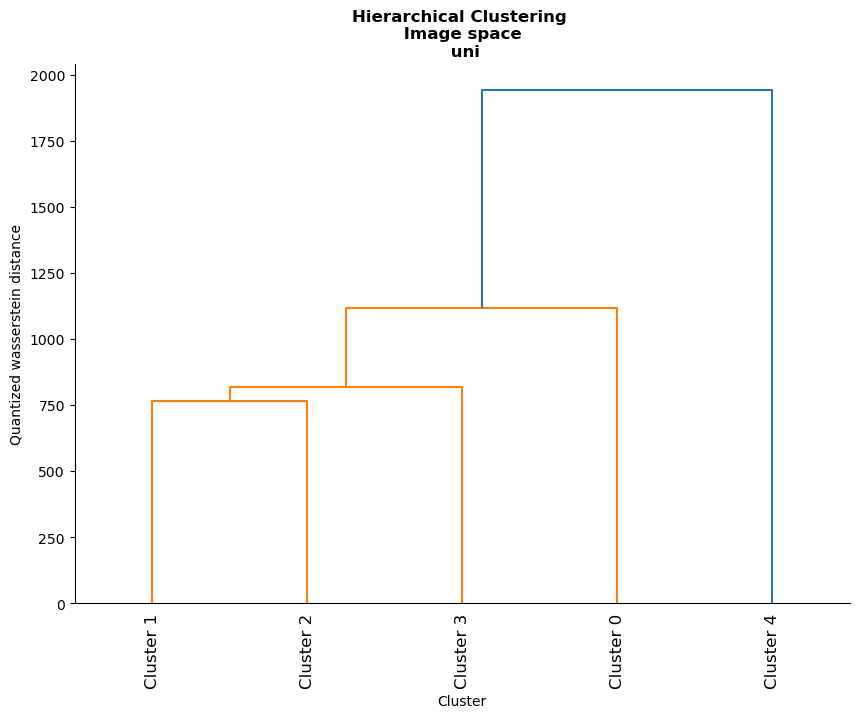

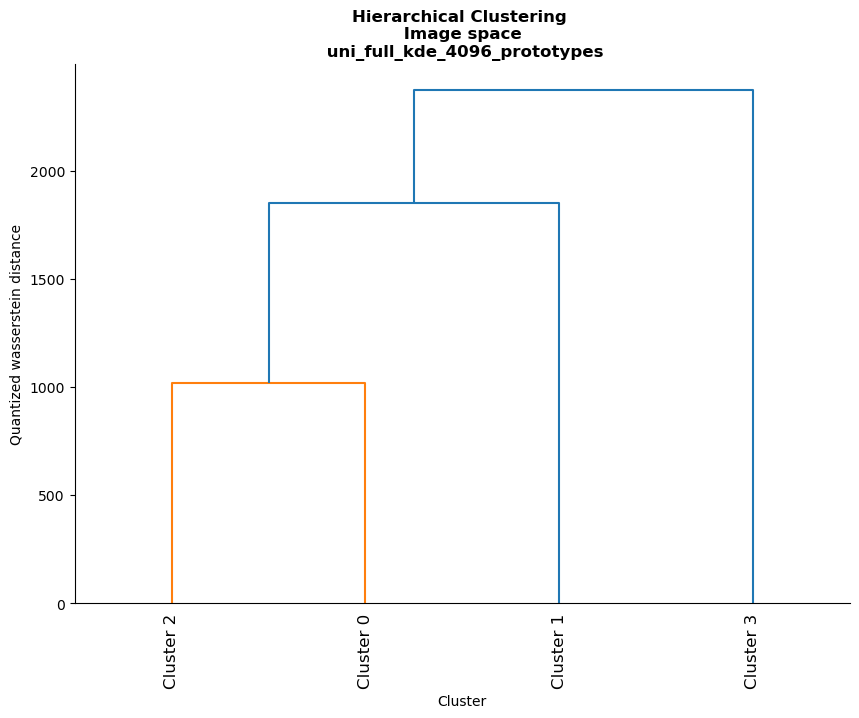

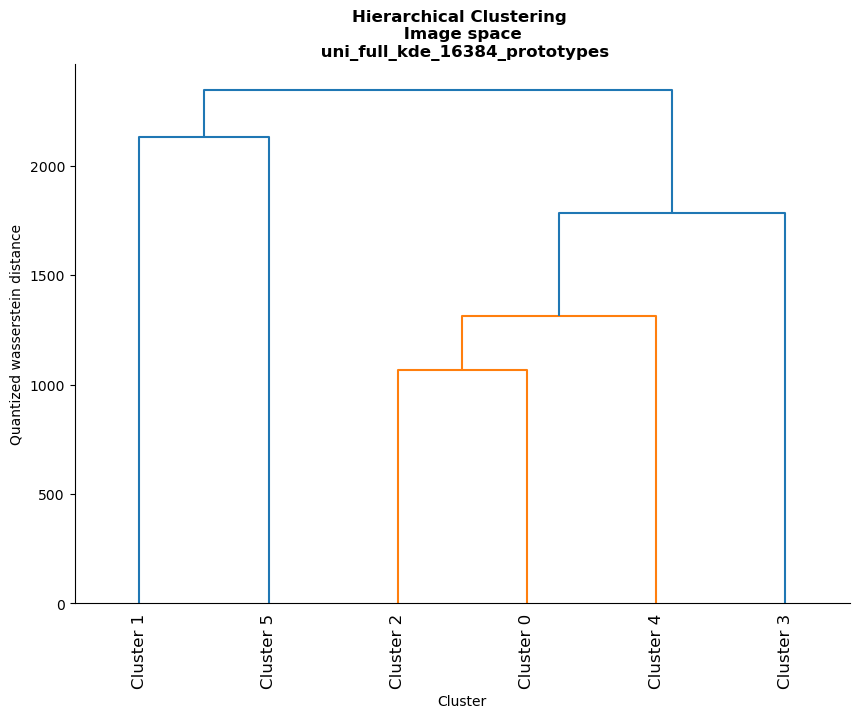

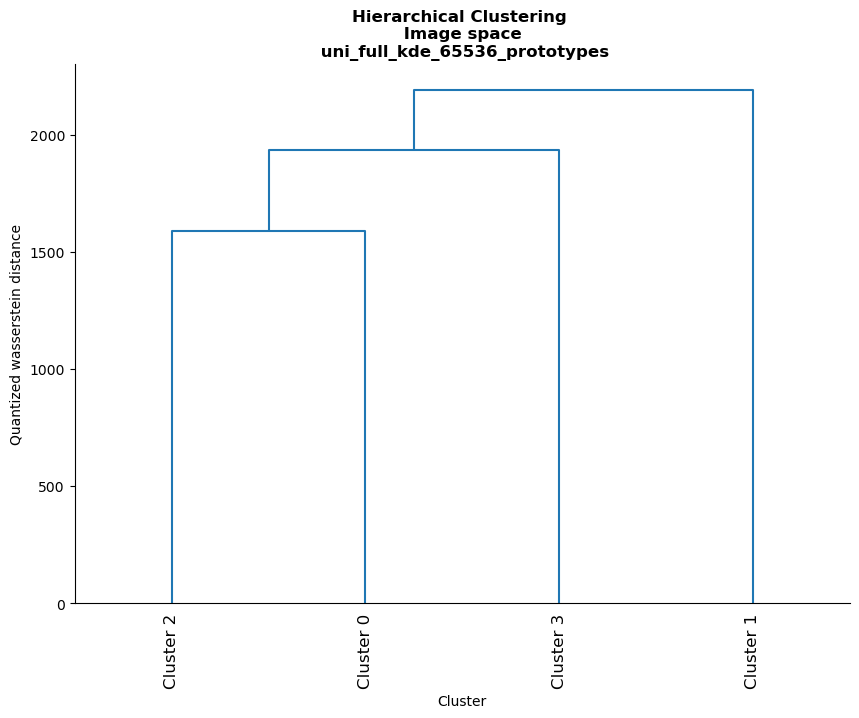

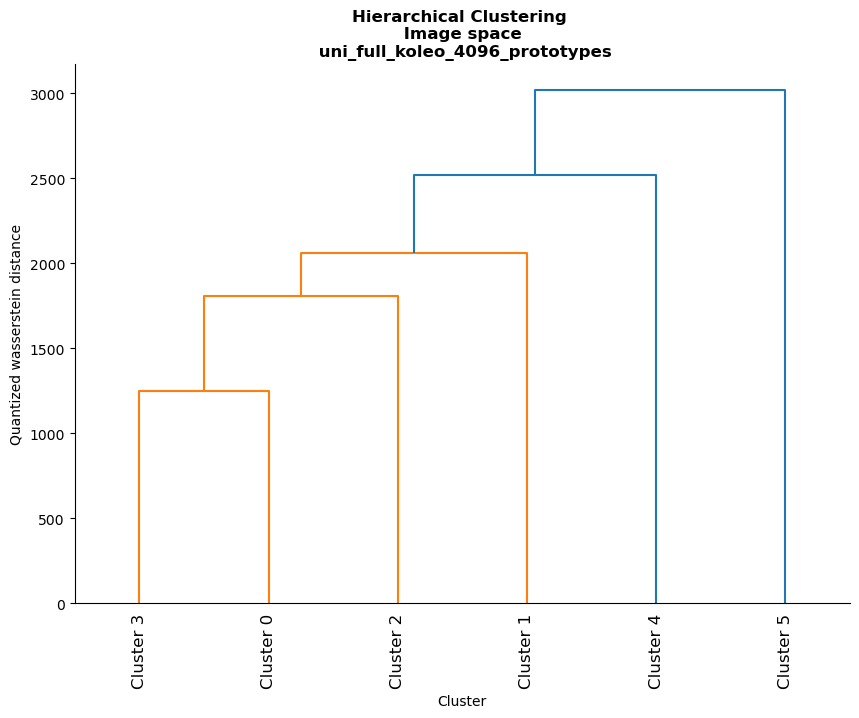

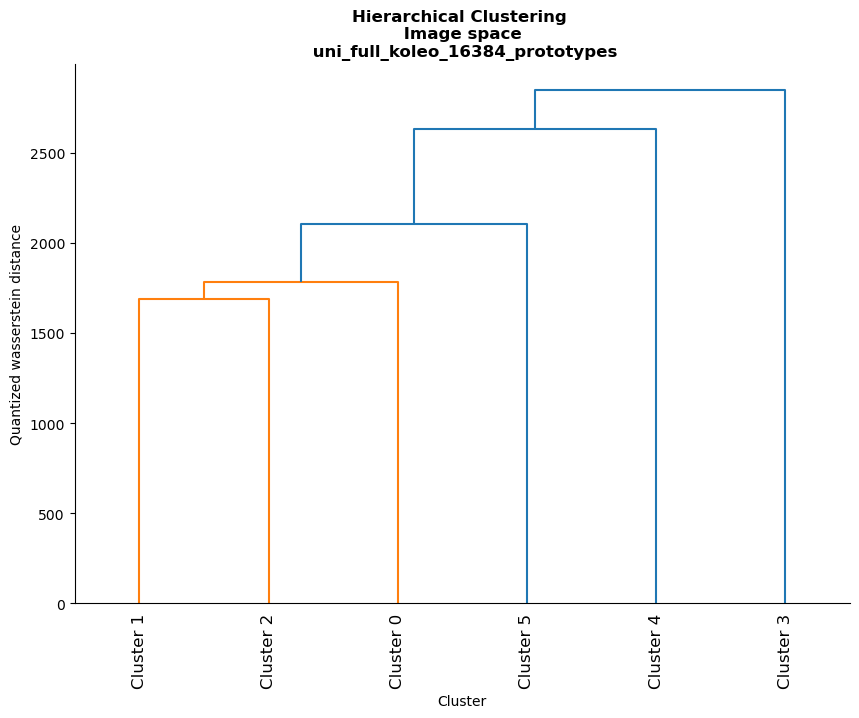

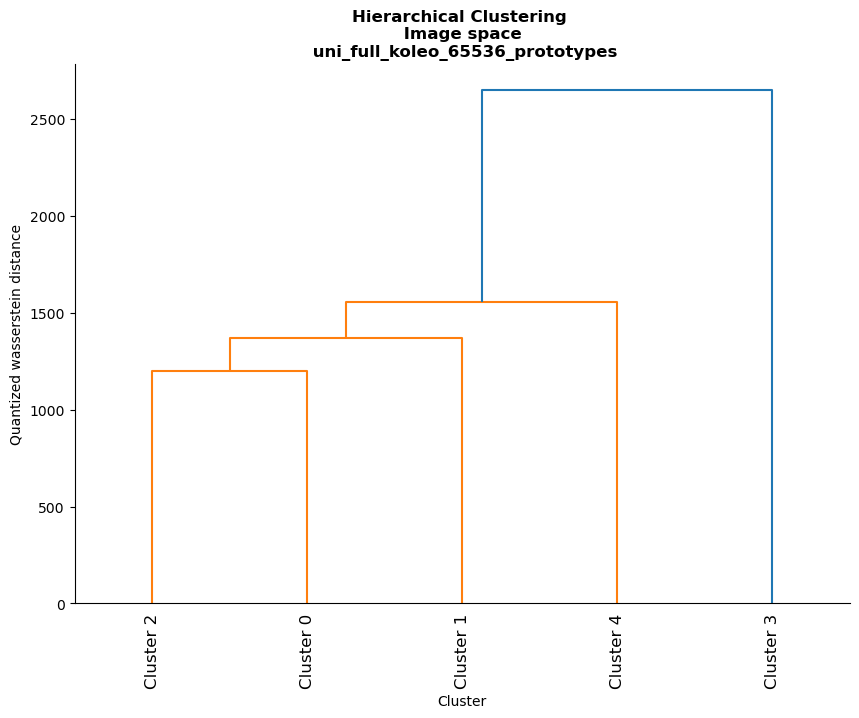

In [5]:

for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                              config['retrained_model_list2_type']],
                              [config['retrained_model_list1'],
                                config['retrained_model_list2']],
                                [config['retrained_benchmark_folder1'],
                                config['retrained_benchmark_folder2']]):
  path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
  
  opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
  for name in names:

        
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        
        filenames = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, f"kmeans/{name}/quantized_wasserstein_distance_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv"))
        
        for filename in filenames:
            
            base_name = os.path.basename(filename)
            
            quantized_wasserstein = pd.read_csv(filename, index_col=0)
            quantized_wasserstein.columns = [f"Cluster {col}" for col in quantized_wasserstein.columns]
            quantized_wasserstein.index = [f"Cluster {idx}" for idx in quantized_wasserstein.index]

            # Perform hierarchical clustering
            linked = sch.linkage(quantized_wasserstein, method='ward')

            # Plot the dendrogram
            plt.figure(figsize=(10, 7))
            dendrogram = sch.dendrogram(linked, labels=quantized_wasserstein.columns, orientation='top', distance_sort='descending', show_leaf_counts=True)
            plt.title(f'Hierarchical Clustering \n Image space \n {name}', weight='bold')
            plt.xlabel('Cluster')
            plt.ylabel('Quantized wasserstein distance')
            plt.xticks(rotation=90)
            sns.despine()
            
            plt.savefig(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"dendrogram_{base_name.split('.csv')[0]}.pdf"), bbox_inches='tight')

In [6]:
import mantel
 

results_mantel = {}
for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                config['retrained_model_list2_type']],
                                [config['retrained_model_list1'],
                                config['retrained_model_list2']],
                                [config['retrained_benchmark_folder1'],
                                config['retrained_benchmark_folder2']]):

    
    
    path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
    
    optimal_cluster_numbers = opti_clusters.loc[names, 'n_clusters'].values

    
    
    for name, cluster_number in zip(names, optimal_cluster_numbers):


        #if name != "uni" and name != "uni_full_kde_4096_prototypes":
        
        results_mantel[name] = {}
        
        print(name)
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)

        cluster_number = opti_clusters.loc[name, 'n_clusters']
        
        # cluster_number = os.path.basename(filename).split("_")[-4]

        patients_files = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{cluster_number}_clusters_patient_*.csv"))
        patients = [os.path.basename(f).split(f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{cluster_number}_clusters_patient_")[1].split(".csv")[0] for f in patients_files]

        patients = list(set(patients))
        mantel_correlations = []
        for i in range(len(patients)):
            for j in range(i+1, len(patients)):
                # distance_matrix1 = pd.read_csv(f"../results/benchmark/her2_final_without_A/uni_full_models/invasive_cancer_clustering/kmeans/uni_full_koleo_16384_prototypes/quantized_wasserstein_distance_molecular_raw_filtered_normalized_uni_full_koleo_16384_prototypes_{cluster_number}_clusters_patient_{patients[i]}.csv", index_col=0)
                # distance_matrix2 = pd.read_csv(f"../results/benchmark/her2_final_without_A/uni_full_models/invasive_cancer_clustering/kmeans/uni_full_koleo_16384_prototypes/quantized_wasserstein_distance_molecular_raw_filtered_normalized_uni_full_koleo_16384_prototypes_{cluster_number}_clusters_patient_{patients[j]}.csv", index_col=0)
                distance_matrix1 = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{cluster_number}_clusters_patient_{patients[i]}.csv"), index_col=0)
                distance_matrix2 = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{cluster_number}_clusters_patient_{patients[j]}.csv"), index_col=0)

                    
                # find the common clusters
                common_clusters = list(set(distance_matrix1.index).intersection(set(distance_matrix2.index)))
                distance_matrix1 = distance_matrix1.loc[common_clusters][[str(cluster) for cluster in common_clusters]]
                distance_matrix2 = distance_matrix2.loc[common_clusters][[str(cluster) for cluster in common_clusters]]
                print(f"Common clusters between {patients[i]} and {patients[j]}: {common_clusters}")
                    
                ## order the matrices
                # distance_matrix1 = (distance_matrix1.loc[list(range(cluster_number))])[[str(i) for i in range(cluster_number)]]
                # distance_matrix2 = (distance_matrix2.loc[list(range(cluster_number))])[[str(i) for i in range(cluster_number)]]
                if distance_matrix1.shape[0] > 2 or distance_matrix2.shape[0] > 2:

                    mantel_corr = mantel.test(distance_matrix1.values, distance_matrix2.values, perms=1000, method='pearson', tail='upper')
                    mantel_correlations.append(mantel_corr.r)
        results_mantel[name] = mantel_correlations

uni
Common clusters between TNBC30 and TNBC66: [1, 3]
Common clusters between TNBC30 and TNBC85: [1, 2, 3]
Common clusters between TNBC30 and TNBC56: [0, 1, 2, 3]
Common clusters between TNBC30 and TNBC27: [1, 2, 3]
Common clusters between TNBC30 and TNBC82: [0, 1, 2, 3]
Common clusters between TNBC30 and TNBC80: [0, 2, 3]
Common clusters between TNBC30 and TNBC75: [3]
Common clusters between TNBC30 and TNBC95: [1]
Common clusters between TNBC30 and TNBC21: [0, 1, 2, 3]
Common clusters between TNBC30 and TNBC12: [1, 2, 3]
Common clusters between TNBC30 and TNBC81: [0, 1, 2]
Common clusters between TNBC30 and TNBC43: [1, 2, 3]
Common clusters between TNBC30 and TNBC51: [2]
Common clusters between TNBC30 and TNBC53: [0, 2]
Common clusters between TNBC30 and TNBC54: [3]
Common clusters between TNBC30 and TNBC8: [1, 3]
Common clusters between TNBC30 and TNBC15: [1, 2, 3]
Common clusters between TNBC30 and TNBC41: [1, 2, 3]
Common clusters between TNBC30 and TNBC78: [0, 1, 2, 3]
Common clus

In [7]:
results_mantel.keys()

dict_keys(['uni', 'uni_explora_kde_4096_prototypes', 'uni_explora_kde_16384_prototypes', 'uni_explora_kde_65536_prototypes', 'uni_explora_koleo_4096_prototypes', 'uni_explora_koleo_16384_prototypes', 'uni_explora_koleo_65536_prototypes', 'uni_full_kde_4096_prototypes', 'uni_full_kde_16384_prototypes', 'uni_full_kde_65536_prototypes', 'uni_full_koleo_4096_prototypes', 'uni_full_koleo_16384_prototypes', 'uni_full_koleo_65536_prototypes'])

In [8]:
results_mantel_df = pd.DataFrame.from_dict(results_mantel, orient='index').T

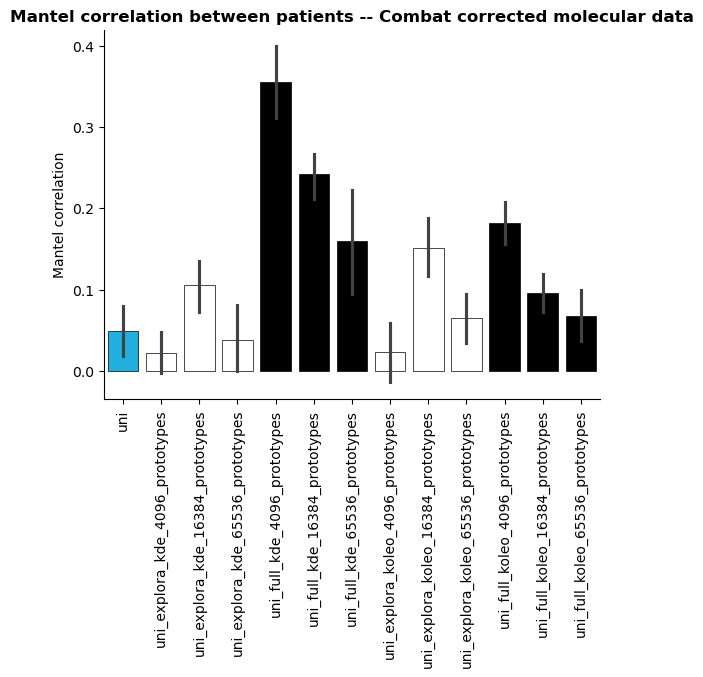

In [9]:


df = pd.DataFrame.from_dict(results_mantel, orient='index').T[["uni",
              "uni_explora_kde_4096_prototypes",
              "uni_explora_kde_16384_prototypes",
                "uni_explora_kde_65536_prototypes",
                "uni_full_kde_4096_prototypes",
                "uni_full_kde_16384_prototypes",
                "uni_full_kde_65536_prototypes",
                "uni_explora_koleo_4096_prototypes",
                "uni_explora_koleo_16384_prototypes",
                "uni_explora_koleo_65536_prototypes",
                "uni_full_koleo_4096_prototypes",
                "uni_full_koleo_16384_prototypes",
                "uni_full_koleo_65536_prototypes"]]



sns.barplot(df, palette=["deepskyblue", "white", "white", "white", "black", 
         "black", "black", "white", 
         "white", "white", "black", "black", "black",],            
            linewidth=0.5,
            edgecolor="black",)
plt.xticks(rotation=90)
sns.despine()
plt.title("Mantel correlation between patients -- Combat corrected molecular data", weight='bold')
plt.ylabel("Mantel correlation")
plt.savefig(os.path.join(config['figures_folder'], "Figure4", "mantel_correlation_dendrogram_patients_raw_filtered_normalized_data.pdf"), bbox_inches='tight')

Text(0, 0.5, 'Mantel correlation')

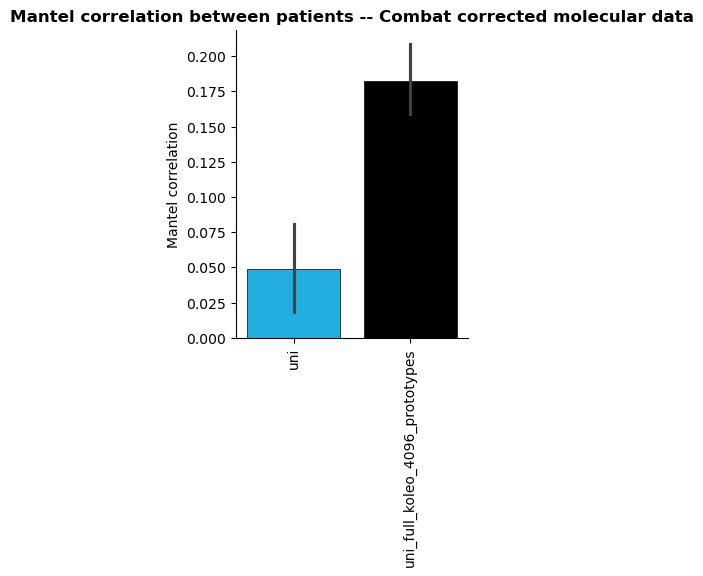

In [10]:
plt.figure(figsize=(3,4))
sns.barplot(df[["uni", "uni_full_koleo_4096_prototypes"]], palette=["deepskyblue", "black",],            
            linewidth=0.5,
            edgecolor="black",)
plt.xticks(rotation=90)
sns.despine()
plt.title("Mantel correlation between patients -- Combat corrected molecular data", weight='bold')
plt.ylabel("Mantel correlation")


In [11]:
import mantel
 

results_mantel = {}
for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                config['retrained_model_list2_type']],
                                [config['retrained_model_list1'],
                                config['retrained_model_list2']],
                                [config['retrained_benchmark_folder1'],
                                config['retrained_benchmark_folder2']]):

    
    
    path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
    
    optimal_cluster_numbers = opti_clusters.loc[names, 'n_clusters'].values

    
    
    for name, cluster_number in zip(names, optimal_cluster_numbers):


        #if name != "uni" and name != "uni_full_kde_4096_prototypes":
        
        results_mantel[name] = {}
        
        print(name)
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)

        cluster_number = opti_clusters.loc[name, 'n_clusters']
        
        # cluster_number = os.path.basename(filename).split("_")[-4]

        patients_files = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"quantized_wasserstein_distance_image_{name}_{cluster_number}_clusters_patient_*.csv"))
        patients = [os.path.basename(f).split(f"quantized_wasserstein_distance_image_{name}_{cluster_number}_clusters_patient_")[1].split(".csv")[0] for f in patients_files]

        patients = list(set(patients))
        mantel_correlations = []
        for i in range(len(patients)):
            for j in range(i+1, len(patients)):
                # distance_matrix1 = pd.read_csv(f"../results/benchmark/her2_final_without_A/uni_full_models/invasive_cancer_clustering/kmeans/uni_full_koleo_16384_prototypes/quantized_wasserstein_distance_image_uni_full_koleo_16384_prototypes_{cluster_number}_clusters_patient_{patients[i]}.csv", index_col=0)
                # distance_matrix2 = pd.read_csv(f"../results/benchmark/her2_final_without_A/uni_full_models/invasive_cancer_clustering/kmeans/uni_full_koleo_16384_prototypes/quantized_wasserstein_distance_image_uni_full_koleo_16384_prototypes_{cluster_number}_clusters_patient_{patients[j]}.csv", index_col=0)
                distance_matrix1 = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"quantized_wasserstein_distance_image_{name}_{cluster_number}_clusters_patient_{patients[i]}.csv"), index_col=0)
                distance_matrix2 = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"quantized_wasserstein_distance_image_{name}_{cluster_number}_clusters_patient_{patients[j]}.csv"), index_col=0)

                    
                # find the common clusters
                common_clusters = list(set(distance_matrix1.index).intersection(set(distance_matrix2.index)))
                distance_matrix1 = distance_matrix1.loc[common_clusters][[str(cluster) for cluster in common_clusters]]
                distance_matrix2 = distance_matrix2.loc[common_clusters][[str(cluster) for cluster in common_clusters]]
                print(f"Common clusters between {patients[i]} and {patients[j]}: {common_clusters}")
                    
                ## order the matrices
                # distance_matrix1 = (distance_matrix1.loc[list(range(cluster_number))])[[str(i) for i in range(cluster_number)]]
                # distance_matrix2 = (distance_matrix2.loc[list(range(cluster_number))])[[str(i) for i in range(cluster_number)]]
                if distance_matrix1.shape[0] > 2 or distance_matrix2.shape[0] > 2:

                    mantel_corr = mantel.test(distance_matrix1.values, distance_matrix2.values, perms=1000, method='pearson', tail='upper')
                    mantel_correlations.append(mantel_corr.r)
        results_mantel[name] = mantel_correlations

uni
Common clusters between TNBC30 and TNBC66: [1, 3]
Common clusters between TNBC30 and TNBC85: [1, 2, 3]
Common clusters between TNBC30 and TNBC56: [0, 1, 2, 3]
Common clusters between TNBC30 and TNBC27: [1, 2, 3]
Common clusters between TNBC30 and TNBC82: [0, 1, 2, 3]
Common clusters between TNBC30 and TNBC80: [0, 2, 3]
Common clusters between TNBC30 and TNBC75: [3]
Common clusters between TNBC30 and TNBC95: [1]
Common clusters between TNBC30 and TNBC21: [0, 1, 2, 3]
Common clusters between TNBC30 and TNBC12: [0, 1, 2, 3]
Common clusters between TNBC30 and TNBC81: [0, 1, 2]
Common clusters between TNBC30 and TNBC43: [1, 2, 3]
Common clusters between TNBC30 and TNBC51: [2, 3]
Common clusters between TNBC30 and TNBC53: [0, 1, 2]
Common clusters between TNBC30 and TNBC8: [1, 2, 3]
Common clusters between TNBC30 and TNBC54: [3]
Common clusters between TNBC30 and TNBC15: [0, 1, 2, 3]
Common clusters between TNBC30 and TNBC41: [1, 2, 3]
Common clusters between TNBC30 and TNBC78: [0, 1, 2,

Text(0.5, 1.0, 'Mantel correlation between patients -- Image embedding space data')

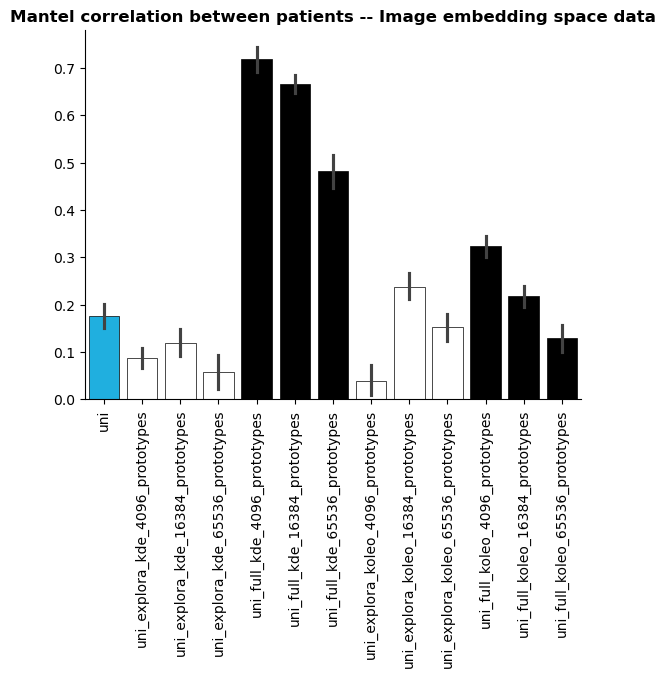

In [12]:
df = pd.DataFrame.from_dict(results_mantel, orient='index').T[["uni",
              "uni_explora_kde_4096_prototypes",
              "uni_explora_kde_16384_prototypes",
                "uni_explora_kde_65536_prototypes",
                "uni_full_kde_4096_prototypes",
                "uni_full_kde_16384_prototypes",
                "uni_full_kde_65536_prototypes",
                "uni_explora_koleo_4096_prototypes",
                "uni_explora_koleo_16384_prototypes",
                "uni_explora_koleo_65536_prototypes",
                "uni_full_koleo_4096_prototypes",
                "uni_full_koleo_16384_prototypes",
                "uni_full_koleo_65536_prototypes"]]



sns.barplot(df, palette=["deepskyblue", "white", "white", "white", "black", 
         "black", "black", "white", 
         "white", "white", "black", "black", "black",],            
            linewidth=0.5,
            edgecolor="black",)
plt.xticks(rotation=90)
sns.despine()
plt.title("Mantel correlation between patients -- Image embedding space data", weight='bold')

Text(0, 0.5, 'Mantel correlation')

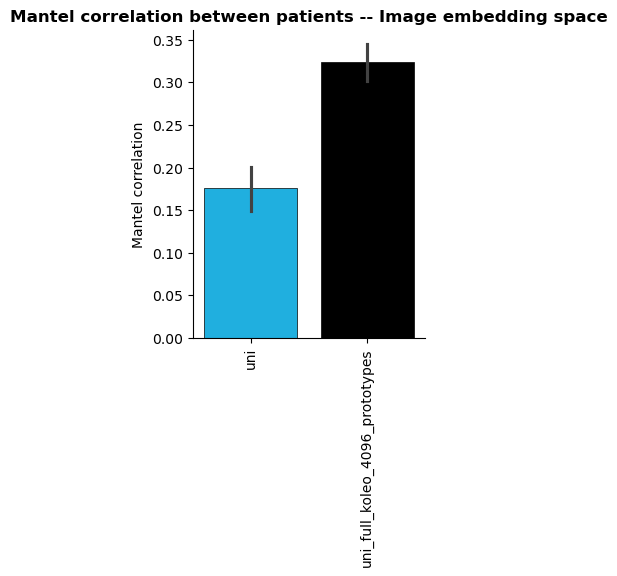

In [13]:
plt.figure(figsize=(3,4))
sns.barplot(df[["uni", "uni_full_koleo_4096_prototypes"]], palette=["deepskyblue", "black",],            
            linewidth=0.5,
            edgecolor="black",)
plt.xticks(rotation=90)
sns.despine()
plt.title("Mantel correlation between patients -- Image embedding space", weight='bold')
plt.ylabel("Mantel correlation")
